Kobe Bryant marked his retirement from the NBA by scoring 60 points in his final game as a Los Angeles Laker on Wednesday, April 12, 2016. Drafted into the NBA at the age of 17, Kobe earned the sport’s highest accolades throughout his long career.

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? 

### Workflow Stages:
1. Goals
2. EDA
3. Models

### Goals:
1. Analyze data set.
2. Discovering knowledge about data set.
3. Build build a good quality classifier to shots selection

## 1. Analyze data set

In [1]:
# Loading Libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings(action = 'ignore')

C:\Users\admin\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\admin\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Loading Data

pd.set_option('display.max_columns', None)
df = pd.read_csv('data.csv')

In [3]:
df.head(5)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
# Size of the dataset

df.shape

(30697, 25)

In [5]:
# types of dataseries and missing variables
pd.DataFrame(data = {"featurs":df.dtypes.values,
                     "is null":df.isnull().sum().values},
             index = df.dtypes.index)

,featurs,is null
action_type,object,0
combined_shot_type,object,0
game_event_id,int64,0
game_id,int64,0
lat,float64,0
loc_x,int64,0
loc_y,int64,0
lon,float64,0
minutes_remaining,int64,0
period,int64,0


In [6]:
# Split dataset 

Shots_to_predict = df[df['shot_made_flag'].isnull()]
Shots_to_train = df[df['shot_made_flag'].notna()]

In [7]:
# Numeric features

Shots_to_train.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000
mean,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
std,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000
25%,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000
50%,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
75%,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000
max,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [8]:
# Categorical features

Shots_to_train.select_dtypes(['object']).describe()

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,25697,25697,25697,25697,25697,25697,25697,25697,25697,25697,25697
unique,55,6,20,2,6,7,5,1,1558,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,15836,19710,1924,20285,11289,10532,7857,25697,43,853,1638


In [9]:
Shots_to_predict.select_dtypes(['object']).describe()

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000
unique,49,6,20,2,6,7,5,1,1457,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2006-12-29,LAL vs. SAS,SAS
freq,3044,3775,394,3986,2166,2093,1541,5000,14,171,340


In [10]:
# Distibution of made shots

Shots_to_train['shot_made_flag'].value_counts(normalize = True)

0.0    0.553839
1.0    0.446161
Name: shot_made_flag, dtype: float64

In [11]:
Shots_to_train.agg(['mean','median','skew'])

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
mean,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
median,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
skew,0.061034,1.709613e+00,-0.840687,-0.084930,0.840687,-0.084930,0.197624,0.054171,2.002425,0.035252,0.127209,0.216628,0.000000e+00,0.002354


## 2. Discovering knowledge about data set

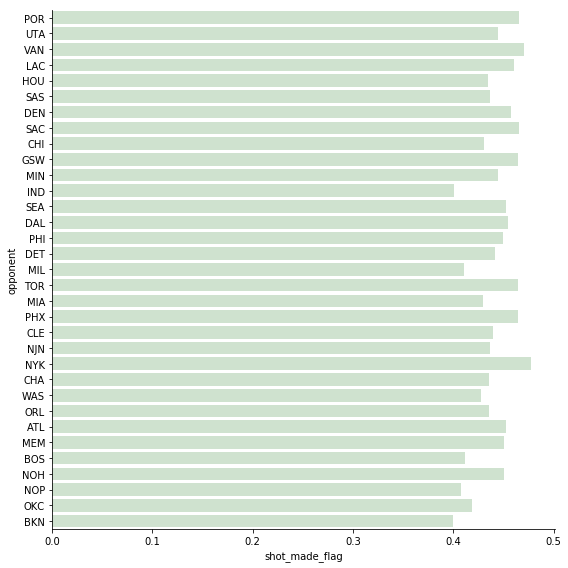

In [12]:
# Kobes's shots percentage for different opponents

f = sns.FacetGrid(Shots_to_train, size = 8)
f.map(sns.barplot,'shot_made_flag','opponent',ci = None, color = 'green', alpha = 0.2);

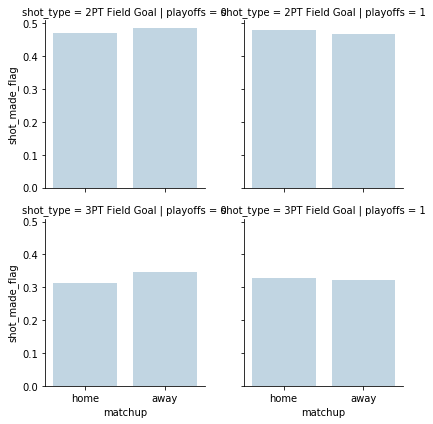

In [13]:
# Find out if playing in front of LA fans was essentials for Kobe's efficiency

Shots_to_train['matchup'] = Shots_to_train['matchup'].apply(lambda x: 'home' if x[:6] == 'LAL vs' else 'away')
g = sns.FacetGrid(Shots_to_train,row = 'shot_type', col = 'playoffs' ,size = 3)
g.map(sns.barplot,'matchup','shot_made_flag', ci =None, alpha = 0.3);

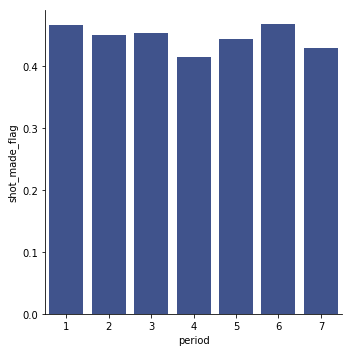

In [14]:
# Percentage of made shots for respective periods
period = sns.FacetGrid(Shots_to_train, size = 5)
period.map(sns.barplot, 'period','shot_made_flag',ci = None, color = [0.2,0.3,0.6])

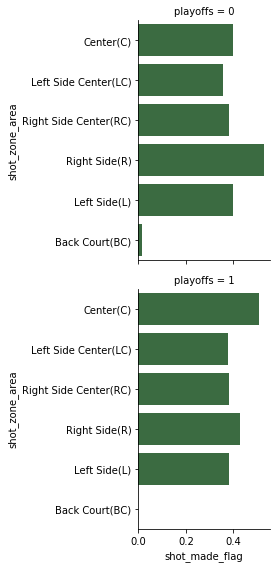

In [15]:
#Kobe's goals percentage depends on a position on the court
s = sns.FacetGrid(Shots_to_train, row = 'playoffs', size= 4)
s.map(sns.barplot, "shot_made_flag",'shot_zone_area',ci = None, color = [0.2,0.45,0.23])

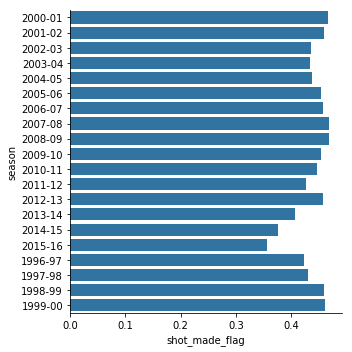

In [16]:
# Kobe's goals percentage over the years
seasons = sns.FacetGrid(Shots_to_train, size = 5)
seasons.map(sns.barplot, 'shot_made_flag','season', ci = None);

In [17]:
#Overview of each action type percentage
Shots_to_train[['action_type','shot_made_flag']].groupby('action_type').mean().assign(number_of_occurance = Shots_to_train['action_type'].value_counts()).sort_values(by = 'number_of_occurance',ascending = False)

,shot_made_flag,number_of_occurance
action_type,,
Jump Shot,0.326913,15836
Layup Shot,0.385330,2154
Driving Layup Shot,0.741400,1628
Turnaround Jump Shot,0.598204,891
Fadeaway Jump Shot,0.574541,872
Running Jump Shot,0.747112,779
Pullup Jump shot,0.723881,402
Turnaround Fadeaway shot,0.584699,366
Slam Dunk Shot,0.982036,334


In [18]:
# There are 6 more unique actions type in the Shots to train than to predict
# To remove excess of it:

Shots_to_train = Shots_to_train.loc[(Shots_to_train['action_type'].isin(Shots_to_predict['action_type'].unique())),:]
Shots_to_train.shape

(25674, 25)

### Conclusions for analysis:

1. To avoid overfitting I choose a few features which I believe have the most impact to shot success.
2. Action type seems to be a feature that strongly determines if action ends up with points. 
3. 2 pt field goal percentage is around 15 points higher than the 3pt field goal percentage

## 3. Build build a good quality classifier to shots selection

In [19]:
def create_dataset(in_data):
    
    in_data['time_remaining'] = (48 - in_data['period'].values*12 + in_data['minutes_remaining'].values)

    dataset = in_data[['shot_distance','minutes_remaining']]
    dataset = pd.concat([dataset, pd.get_dummies(in_data['action_type'],prefix = "_")],axis =1)
    dataset = pd.concat([dataset, pd.get_dummies(in_data['shot_type'], prefix = 'shot_type')],axis =1)
    dataset = pd.concat([dataset, pd.get_dummies(in_data['shot_zone_area'], prefix = 'zone')], axis =1)
    dataset= pd.concat([dataset, pd.get_dummies(in_data['playoffs'], prefix = 'offs')], axis =1)
    dataset = pd.concat([dataset,pd.get_dummies(in_data['period'], prefix = 'Q')], axis = 1)
    
    return dataset


In [20]:
X = create_dataset(Shots_to_train)
y = Shots_to_train[['shot_made_flag']]
X_sub = create_dataset(Shots_to_predict)
X_sub = X_sub.drop(columns="__Running Tip Shot", axis = 0)

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.3,random_state = 1,stratify = y)

In [22]:
# Logistic Regresion
Pipe_lr = Pipeline([["scaler",MinMaxScaler(feature_range=(0,1))],
                   ["lr",LogisticRegression()]])

lr_score = cross_val_score(estimator=Pipe_lr,
                        X = X_train,
                        y = y_train,
                         cv = 10)

lr_score = round(lr_score.mean(),ndigits=4)
lr_score_test = round(Pipe_lr.fit(X_train,y_train).score(X_test,y_test), ndigits=4)

In [23]:
# Decision Tree
tree = DecisionTreeClassifier()


tree_score = cross_val_score(estimator=tree,
                            X= X_train,
                            y = y_train,
                            cv = 10)

tree_score = round(tree_score.mean(),ndigits=4)
tree_score_test = round(tree.fit(X_train,y_train).score(X_test,y_test), ndigits=4)

In [24]:
#Random forest
forest = RandomForestClassifier()
forest_score = cross_val_score(estimator=forest,
                              X= X_train,
                              y = y_train,
                              cv = 10)

forest_score = round(forest_score.mean(),ndigits=4)
forest_score_test = round(forest.fit(X_train,y_train).score(X_test,y_test), ndigits=4)

In [25]:
#XGB
pipe_xgb = Pipeline([['scaler',MinMaxScaler(feature_range =(0,1))],
                                            ['xgb',xgb.XGBClassifier()]])

xgb_score = cross_val_score(estimator=pipe_xgb,
                           X = X_train,
                           y=y_train,
                           cv = 10)

xgb_score = round(xgb_score.mean(),ndigits=4)
xgb_score_test = round(pipe_xgb.fit(X_train,y_train).score(X_test,y_test), ndigits=4)

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc_score = cross_val_score(estimator=svc,
                           X = X_train,
                           y = y_train,
                           cv= 10)
svc_score.mean();

In [26]:
# voting Classfiier
clf1 = VotingClassifier(estimators=[('lr',Pipe_lr),('xgb',pipe_xgb)],voting='soft')
clf1_score = cross_val_score(estimator=clf1,
                            X = X_train,
                            y=y_train,
                            cv = 10)

clf1_score = round(clf1_score.mean(),ndigits=4)
clf1_score_test = round(clf1.fit(X_train,y_train).score(X_test,y_test), ndigits=4)

In [27]:
# Models results sum up
models = pd.DataFrame({'Model':['Logisti Regresion', 'Decision Tree','Random Forest','XGB','Clf1'],
                       'Cross Validation Score':[lr_score,tree_score,forest_score,xgb_score,clf1_score],
                       'Test set Score':[lr_score_test,tree_score_test,forest_score_test,xgb_score_test,clf1_score_test]
})
models.sort_values(by = 'Cross Validation Score',ascending = False)

,Model,Cross Validation Score,Test set Score
0,Logisti Regresion,0.6794,0.6853
4,Clf1,0.6773,0.6860
3,XGB,0.6697,0.6766
2,Random Forest,0.6112,0.6069
1,Decision Tree,0.6100,0.6146


In [28]:
## Hyperparameter optimization

# Logistic Regresion
from sklearn.model_selection import RandomizedSearchCV
random_param = {"lr__penalty":["l1","l2"],
                "lr__C":np.logspace(-4,4,50)
               }

model = Pipe_lr
random_search = RandomizedSearchCV(estimator = model,
                                   param_distributions=random_param,
                                   n_iter = 4*4*4*4,
                                   scoring = 'accuracy',
                                   cv = 10
                                  )

random_search.fit(X_train,y_train)
best_params = random_search.best_params_
print(best_params)

{'lr__penalty': 'l1', 'lr__C': 0.3906939937054613}


In [371]:
# Score were not improved
random_search.score(X_test,y_test)

0.6853174088017655

In [388]:
# Create Submission

prob = Pipe_lr.predict_proba(X_sub)[:,1]
new_sub = pd.DataFrame({'Shot_Id':Shots_to_predict['shot_id'],
                        'shot_made_flag':prob})

new_sub.to_csv("Submission_Kobe.csv",index = False)